# Using NP4VTT: Random valuation (RV) model

In this notebook, we show how to use a RV model to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the RV model, and Pandas to load the dataset:

In [13]:
import pandas as pd

from py_np4vtt.data_format import Vars
from py_np4vtt.model_rv import ModelRV, ConfigRV
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [14]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL` and `CostR`: Travel cost of alternatives 1 and 2, respectively.
* `TimeL` and `TimeR`: Travel time of alternatives 1 and 2, respectively.

NP4VTT detects automatically the _slow-cheap_ and _fast-expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

Change currency of travel time to euros and change unit of travel time to hours

In [15]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [16]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [17]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [18]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 10.2977
Minimum of BVTT: 0.6667
Maximum of BVTT: 113.5632


## Step 3: Configure a RV model

The RV model requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.
* `startScale`: The starting value of the scale parameter.
* `startVTT`: The starting value of the VTT parameter.
* `maxIterations:` Maximum iterations of the maximum likelihood estimation routine.


The function `ConfigRV` takes the configuration parameters of the RV and creates an object that is used by the optimisation routine:

In [19]:
config = ConfigRV(minimum=0, maximum=100, supportPoints=100, startScale=0, startVTT=1, maxIterations=10000)

Now, we create the RV model object that contains the configuration parameters and the data arrays. Then, we initialise the arguments and the initial value of the likelihood function:

In [20]:
rv = ModelRV(config, model_arrays)

`ModelRV` creates the VTT grid as specified in `ConfigRV` and can be accessed using the 'dot' notation (i.e., `ModelRV.vtt_grid`)

In [21]:
vtt_grid = rv.vtt_grid
vtt_grid

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

## Step 4: Estimate a RV model

Once the RV is initialised, the `run` method starts the optimisation process:

In [22]:
x, se, p, init_ll, ll, exitflag = rv.run()

The estimated model returns the following information:

* `x:` The estimated parameters for the intercept, the VTT parameter, and the scale.
* `se:` The standard error of the estimated parameters.
* `p`: Choice probabilities evaluated at each point of the VTT grid.
* `init_ll:` Value of the likelihood function evaluated in the starting values.
* `ll:` Value of the likelihood function in the optimum.
* `exitflag:` Exit flag of the optimisation routine. If `exitflag=0` the optimisation routine succeeded.

The following lines present the estimated results:

In [23]:
import numpy as np

# Create dataframe
results = pd.DataFrame(np.c_[x,se],columns=['Estimate','Std.Err'],index=['Scale','VTT'])

print('Estimation results:\n')
print('Initial log-likelihood: ' + str(round(init_ll,2)))
print('Final log-likelihood: ' + str(round(ll,2)))
print('Estimates:')
print(results)

Estimation results:

Initial log-likelihood: -36381.91
Final log-likelihood: -28558.24
Estimates:
       Estimate   Std.Err
Scale  0.084008  0.001039
VTT    7.958185  0.133105


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

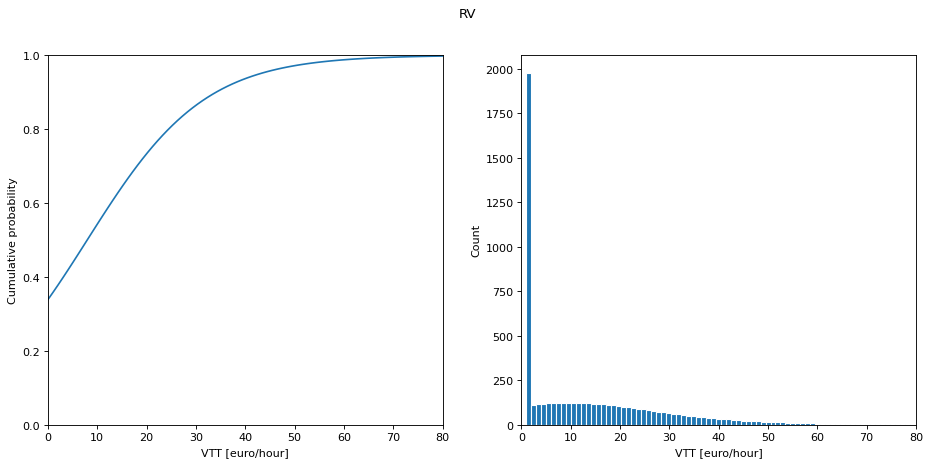

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
# ax[0].plot(vtt_grid_midpoints,np.concatenate((0,mean_f),axis=None),marker='o')
ax[0].plot(vtt_grid,p)
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Cumulative probability')


# Obtain probabilities from the CDF plot
pp = ((np.append(p, 0)-np.append(0,p)))
pp[pp<0] = 0
pp = (np.divide(pp,np.sum(pp)))
pp[-1] = 0
pp = np.append(0,pp)

# Construct data points
data_hist = []
# for n in range(0,len(vtt_grid_midpoints)):
#     dat = [vtt_grid_midpoints[n]]*np.round((pp[n]*descriptives.NP)).astype(int)
#     data_hist = np.append(data_hist,dat)
for n in range(0,len(vtt_grid)):
    dat = [vtt_grid[n]]*np.round((pp[n]*descriptives.NP)).astype(int)
    data_hist = np.append(data_hist,dat)

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(data_hist, bins = vtt_grid,edgecolor="white")
fig.suptitle('RV')
plt.show()